# Análise Exploratória

## Setup & visão geral

> Objetivo: Garantir reprodutibilidade e contexto regulatório

In [1]:
# 1. Criar o ambiente Conda com Python 3.11
# conda create -n ENV_PICPAY python=3.11

# 2. Ativar o ambiente
# conda activate ENV_PICPAY

# 3. Instalar os pacotes listados em requirements.txt
# pip install -r requirements.txt


# importação de bibliotecas
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve
import warnings, os, random
from IPython.display import display, Markdown
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, 
    matthews_corrcoef, 
    precision_score, 
    roc_auc_score, 
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import ks_2samp


# Caminho relativo para a pasta src (do notebook para a raiz e depois src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from utils import CreditRiskEDA, FeatureRelationshipInspector
from audit_trail import AuditTrail

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

sns.set(style='whitegrid')
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

### Funções

In [2]:
def search_dtypes(df, limite_categorico=50, force_categorical=None, verbose=True):
    """
    Identifica colunas numéricas e categóricas em um DataFrame.

    - Força 'client_id' e colunas em `force_categorical` como categóricas, se existirem.
    - Colunas object/string com poucos valores únicos viram 'category'.
    - Colunas numéricas permanecem como estão.

    Parâmetros:
    - df: DataFrame de entrada
    - limite_categorico: máximo de valores únicos para considerar como 'category'
    - force_categorical: lista de colunas que devem ser tratadas como categóricas
    - verbose: se True, imprime detalhes das decisões

    Retorna:
    - num_cols: lista de colunas numéricas
    - cat_cols: lista de colunas categóricas
    """
    num_cols = []
    cat_cols = []

    if force_categorical is None:
        force_categorical = []

    for col in df.columns:
        tipo = df[col].dtype

        # Força colunas explicitamente marcadas como categóricas
        if col == 'client_id' or col in force_categorical:
            cat_cols.append(col)
            if verbose:
                print(f"Forçando '{col}' como categórica.")
            continue

        if tipo == 'object' or tipo.name == 'string':
            unicos = df[col].nunique(dropna=True)
            if unicos <= limite_categorico:
                cat_cols.append(col)
                if verbose:
                    print(f"Coluna '{col}' classificada como 'category' ({unicos} únicos).")
            else:
                if verbose:
                    print(f"Coluna '{col}' tem muitos valores únicos ({unicos}), ignorada.")
        elif pd.api.types.is_numeric_dtype(tipo):
            num_cols.append(col)
        elif pd.api.types.is_bool_dtype(tipo):
            cat_cols.append(col)
        else:
            if verbose:
                print(f"Coluna '{col}' ignorada (tipo: {tipo}).")

    if verbose:
        print(f'\nVariáveis categóricas ({len(cat_cols)}):')
        for col in cat_cols:
            print('> ', col)

        print(f'\nVariáveis numéricas ({len(num_cols)}):')
        for col in num_cols:
            print('> ', col)

    return num_cols, cat_cols


In [3]:
raw_data = pd.read_csv('../data/raw/base_modelo.csv')

print(raw_data.shape)

display(raw_data.head(3))

(10738, 81)


,id,safra,y,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,VAR_9,VAR_10,VAR_11,VAR_12,VAR_13,VAR_14,VAR_15,VAR_16,VAR_17,VAR_18,VAR_19,VAR_20,VAR_21,VAR_22,VAR_23,VAR_24,VAR_25,VAR_26,VAR_27,VAR_28,VAR_29,VAR_30,VAR_31,VAR_32,VAR_33,VAR_34,VAR_35,VAR_36,VAR_37,VAR_38,VAR_39,VAR_40,VAR_41,VAR_42,VAR_43,VAR_44,VAR_45,VAR_46,VAR_47,VAR_48,VAR_49,VAR_50,VAR_51,VAR_52,VAR_53,VAR_54,VAR_55,VAR_56,VAR_57,VAR_58,VAR_59,VAR_60,VAR_61,VAR_62,VAR_63,VAR_64,VAR_65,VAR_66,VAR_67,VAR_68,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78
0,1,201404,0,0.0,0.0,0.0,0.0,124.54,3277.0,51.98,NaN,500.00,153.0,NaN,299.0,73.26,1024.0,26.98,162.0,3000.0,72.0,45.0,8,1279.0,63.0,77.67,492.84,12.0,845.0,NaN,12.0,16.0,500.00,22.0,0.133833,18.0,NaN,NaN,0.0,16.0,220.84,348.0,9.0,9.57,33.0,19.0,11.0,512.82,36.0,0.0,16.0,0.0,159.28,379.0,53.97,3380.00,500.00,159.28,159.28,45,369.0,95.54,-0.030478,0.0,2508.0,159.28,0,1303.79,8.0,-69.0,16.0,156.38,7.52,0.0,151.0,0.0,3.0,477.84,173.06,0.00,3.0
1,2,201407,0,64.0,0.0,2.0,1.0,47.92,2443.0,84.72,NaN,1000.00,649.0,NaN,224.0,38.53,NaN,NaN,84.0,NaN,50.0,18.0,12,1063.0,31.0,177.39,335.44,9.0,NaN,842.0,10.0,NaN,1000.00,14.0,0.133833,13.0,NaN,NaN,NaN,NaN,338.90,179.0,5.0,NaN,NaN,19.0,9.0,269.71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1000.00,2000.00,NaN,NaN,60,228.0,97.73,0.357324,NaN,836.0,NaN,0,1486.26,24.0,NaN,NaN,707.84,NaN,NaN,187.0,NaN,NaN,NaN,184.69,54.00,NaN
2,3,201405,0,99.0,2.0,2.0,2.0,80.38,1824.0,26.63,NaN,1893.35,346.0,29.98,106.0,NaN,NaN,73.55,8.0,NaN,3.0,2.0,12,116.0,4.0,140.25,362.71,3.0,NaN,597.0,5.0,NaN,1893.35,NaN,0.133833,2.0,NaN,59.97,NaN,NaN,133.17,NaN,4.0,NaN,NaN,3.0,12.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,294.20,1893.35,1893.35,NaN,NaN,31,264.0,294.57,-0.411787,NaN,NaN,NaN,0,800.27,18.0,NaN,NaN,471.86,NaN,NaN,96.0,NaN,NaN,NaN,732.00,121.98,NaN


### 📄 Estrutura Geral do Dataset (`raw_data`)

| Coluna    | Tipo Esperado | Descrição Simplificada                    |
|-----------|---------------|-------------------------------------------|
| `id`      | int           | Identificador único do registro           |
| `safra`   | int           | Ano e mês da Safra de Originação (formato YYYYMM)  |
| `y`       | int (0 ou 1)  | Variável alvo (ex: inadimplência)         |
| `VAR_1`   | float         | Variável anônima                          |
| `VAR_2`   | float         | Variável anônima                          |
| `VAR_3`   | float         | Variável anônima                          |
| ...       | ...           | ... até                                   |
| `VAR_78`  | float         | Variável anônima                          |


#### Definição de Tipos

In [4]:
numerical_cols, categorical_cols = search_dtypes(
    raw_data.drop(columns=['id', 'safra', 'y']),  # ignora identificadores e target
    force_categorical=[],                         # permite auto-identificação
    limite_categorico=50,                         # colunas com até 50 valores únicos = categóricas
    verbose=False
)

display(Markdown("### 📊 Tipos de Variáveis Detectadas"))
print(f"🔢 Variáveis Numéricas: {len(numerical_cols)}")
print(f"🔣 Variáveis Categóricas: {len(categorical_cols)}")

print("\n🧮 Numéricas:")
print(", ".join(numerical_cols[:10]) + ("..." if len(numerical_cols) > 10 else ""))

print("\n🔠 Categóricas:")
print(", ".join(categorical_cols[:10]) + ("..." if len(categorical_cols) > 10 else ""))


### 📊 Tipos de Variáveis Detectadas

🔢 Variáveis Numéricas: 78
🔣 Variáveis Categóricas: 0

🧮 Numéricas:
VAR_1, VAR_2, VAR_3, VAR_4, VAR_5, VAR_6, VAR_7, VAR_8, VAR_9, VAR_10...

🔠 Categóricas:



# Seção 1 - Qualidade dos dados

In [5]:
print(f"📅 Período de concessão do crédito:")
print(f"🔹 Safra mais antiga: {raw_data['safra'].min()}")
print(f"🔹 Safra mais recente: {raw_data['safra'].max()}")
print(f"🔢 Total de safras distintas: {raw_data['safra'].nunique()} meses")

📅 Período de concessão do crédito:
🔹 Safra mais antiga: 201401
🔹 Safra mais recente: 201412
🔢 Total de safras distintas: 12 meses


### 🔎 Verificação de Duplicidade em ID

In [6]:
dup_count = raw_data.duplicated(subset='id').sum()
total_ids = raw_data['id'].nunique()
total_rows = len(raw_data)

print("\n" + "="*60)
print("📌 Verificação de Duplicidades no Identificador Primário (id)")
print("="*60)
print(f"👥 Total de linhas: {total_rows:,}")
print(f"🔑 Total de IDs únicos: {total_ids:,}")
print(f"⚠️  IDs duplicados encontrados: {dup_count:,}")
print("="*60)

if dup_count == 0:
    print("✅ Nenhuma duplicidade encontrada no campo 'id'.\n")
else:
    print("❗ Existem registros duplicados. Investigar antes de seguir com o modelo.\n")

if dup_count > 0:
    display(raw_data[raw_data.duplicated(subset='id', keep=False)].sort_values('id').head(10))


📌 Verificação de Duplicidades no Identificador Primário (id)
👥 Total de linhas: 10,738
🔑 Total de IDs únicos: 10,738
⚠️  IDs duplicados encontrados: 0
✅ Nenhuma duplicidade encontrada no campo 'id'.



#### Dados Ausentes, zeros e outliers (z-score/IQR)

In [7]:
# 📊 Análise de Dados Ausentes
missing = (raw_data.isna().mean() * 100).sort_values(ascending=True)
total_missing = (missing > 0).sum()

print("\n" + "="*60)
print(f"🔍 Foram encontradas {total_missing} colunas com dados ausentes.")
print("🧮 Percentual de valores ausentes por coluna:")
print("="*60 + "\n")

missing = missing.to_frame('pct_missing').reset_index()

display(missing.head(100))


🔍 Foram encontradas 72 colunas com dados ausentes.
🧮 Percentual de valores ausentes por coluna:



,index,pct_missing
0,id,0.000000
1,safra,0.000000
2,y,0.000000
3,VAR_32,0.000000
4,VAR_20,0.000000
5,VAR_57,0.000000
6,VAR_60,0.000000
7,VAR_64,0.000000
8,VAR_9,0.000000
9,VAR_30,0.447011


> A quantidade de dados ausentes podem ajudar a nortear a decisão por modelos mais robustos que modelos lineares

### 📊 Verificação de Outliers (Z-Score > 3)

In [8]:
print("\n" + "="*60)
print("🚨 Verificação de Outliers em Colunas Numéricas")
print("Critério: Z-Score absoluto > 3")
print("="*60)

outlier_summary = {}
for col in numerical_cols:
    try:
        z = np.abs(stats.zscore(raw_data[col].dropna()))
        outlier_pct = (z > 3).sum() / len(raw_data) * 100
        outlier_summary[col] = outlier_pct
    except Exception as e:
        print(f"⚠️  Falha ao calcular z-score para '{col}': {e}")

outlier_df = pd.Series(outlier_summary).sort_values(ascending=False)

print(f"🧮 Total de colunas numéricas analisadas: {len(outlier_df)}")
print("🔝 Colunas com maior percentual de outliers:\n")

display(outlier_df.to_frame('pct_outliers>3σ').head(100))


🚨 Verificação de Outliers em Colunas Numéricas
Critério: Z-Score absoluto > 3
🧮 Total de colunas numéricas analisadas: 78
🔝 Colunas com maior percentual de outliers:



,pct_outliers>3σ
VAR_33,2.831067
VAR_19,2.728627
VAR_72,2.710002
VAR_22,2.588936
VAR_3,2.411995
VAR_1,2.216428
VAR_4,2.141926
VAR_65,2.104675
VAR_54,1.937046
VAR_53,1.862544


### 🔍 Identificação e Remoção de Colunas com Valor Único

In [9]:
print("\n" + "="*60)
print("🧹 Verificação de Colunas com Valor Único (excluindo NaN)")
print("="*60)

unique_cols = [
    col for col in raw_data.columns 
    if raw_data[col].nunique(dropna=True) == 1
]

if unique_cols:
    print(f"🔎 Foram encontradas {len(unique_cols)} colunas com valor único:")
    for col in unique_cols:
        unique_val = raw_data[col].dropna().unique()
        val_str = unique_val[0] if len(unique_val) > 0 else 'NaN'
        print(f"  - {col}: {val_str}")
    
    # ✂️ Remoção
    raw_data.drop(columns=unique_cols, inplace=True)
    print(f"✅ Colunas removidas: {unique_cols}")
else:
    print("✅ Nenhuma coluna com valor único encontrada.")

print("="*60 + "\n")



🧹 Verificação de Colunas com Valor Único (excluindo NaN)
✅ Nenhuma coluna com valor único encontrada.



# Seção 2 – Target & Desbalanceamento

In [10]:
TARGET_COL = 'y'

event_rate = raw_data[TARGET_COL].mean()
print(f'Event rate (inadimplência): {event_rate:.2%}')

Event rate (inadimplência): 29.13%


#### Target (y) representaria Inadimplência Presente ou Futura?

In [11]:
# Para ser inadimplência presente, precisaria que todos os valores após determinado limiar de atraso implicassem em y=1

# possível localizar isso?

# alguma coluna poderia ser a melhor candidata a ser dias_atraso?

# como identificar?

# resposta: a feature com maior correlação com target tem chance de ser dias_atraso

#### Qual feature tem mais chance de representar DPD (dias de atraso) ?

In [12]:
# --- IDENTIFICAR CANDIDATAS (NUMÉRICAS E NÃO-NEGATIVAS) ---
candidate_columns = []
for col in raw_data.columns:
    # Ignorar colunas que não são features, como id, safra e a própria alvo
    if col in ['id', 'safra', 'y']:
        continue
    
    # Verificar se a coluna é numérica e se o valor mínimo é >= 0
    if pd.api.types.is_numeric_dtype(raw_data[col]):
        if raw_data[col].min(skipna=True) >= 0:
            candidate_columns.append(col)

print(f"Encontradas {len(candidate_columns)} colunas numéricas com valores não-negativos.")
print("-" * 60)

Encontradas 65 colunas numéricas com valores não-negativos.
------------------------------------------------------------


In [13]:
# --- ENCONTRAR A MAIOR CORRELAÇÃO COM A INADIMPLÊNCIA (y) ---
# Calcula a correlação de todas as candidatas com a variável 'y'
correlations = raw_data[candidate_columns].corrwith(raw_data['y']).sort_values(ascending=False)

# Pega o nome e o valor da coluna com a maior correlação positiva
best_candidate_col = correlations.index[0]
best_correlation_val = correlations.iloc[0]

print("Correlação com a variável alvo 'y' (inadimplência)")
print(f"Principal candidata a 'dias de atraso': '{best_candidate_col}'")
print(f"Valor da Correlação: {best_correlation_val:.4f}\n")
print("Top 5 candidatas:")
print(correlations.head())
print("-" * 60)

Correlação com a variável alvo 'y' (inadimplência)
Principal candidata a 'dias de atraso': 'VAR_1'
Valor da Correlação: 0.3360

Top 5 candidatas:
VAR_1     0.336045
VAR_2     0.215004
VAR_20    0.167523
VAR_3     0.157032
VAR_49    0.149693
dtype: float64
------------------------------------------------------------


In [14]:
# --- ANÁLISE DETALHADA DA COLUNA SELECIONADA ---
print(f"Analisando em detalhes a coluna '{best_candidate_col}'...\n")

# Exibir estatísticas descritivas
print("Estatísticas Descritivas:")
print(raw_data[best_candidate_col].describe())
print("-" * 60)

Analisando em detalhes a coluna 'VAR_1'...

Estatísticas Descritivas:
count    10322.000000
mean        32.999225
std         46.367685
min          0.000000
25%          0.000000
50%         16.000000
75%         46.000000
max        208.000000
Name: VAR_1, dtype: float64
------------------------------------------------------------


In [15]:
# Como um contrato "novo" originado na safra atual, ter atraso superior a 30 dias?

# Simples: o contrato pode ser fruto de reestruturação de contrato anterior

# Neste caso, é importante que não haja re-aging (rejuvenecimento de condição de atraso), sob pena de subestimativa de risco.

# após uma fase de default, os contratos passam por etapa de workout (redução de sua condição de inadimplência), para posterior cura

# a cura é um período de prova de resiliência de saúde creditícia, onde o gap_cure deve ser construído com base em política de risco de crédito.

# As 4966/21 não fecha um intervalo mínimo de cura, mas em geral se usam ao menos 3 meses sem quaisquer atrasos ou dívidas remanecentes.

# Esse tempo de cura pode ser conforme segmentos de carteiras (com ou sem garantias fiduciárias)


# Quanto maior o tempo de cura exigido, mais conservadora é a abordagem

# pois o contrato permanece por mais tempo em estágios de maior risco, o que pode resultar em maior provisão de perda esperada (ECL) durante esse período.

### Histograma de "Dias de Atraso"

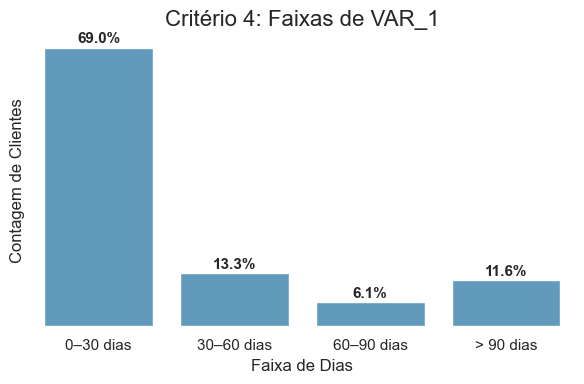

In [16]:
# --- Preparação: Faixas de atraso ---
coluna = best_candidate_col
valores = raw_data[coluna].dropna()

bins = [0, 30, 60, 90, valores.max()]
labels = ['0–30 dias', '30–60 dias', '60–90 dias', '> 90 dias']
faixas = pd.cut(valores, bins=bins, labels=labels, right=True, include_lowest=True)

frequencia = faixas.value_counts(sort=False)
porcentagem = (frequencia / frequencia.sum() * 100).round(1)

# --- Paleta de cores
cor_fixa = sns.color_palette("Blues")[3]
PALETTE = ['#77BDD9', '#0A3873']  # y=0, y=1

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# --- Gráfico: Histograma por faixas ---
sns.barplot(
    x=frequencia.index,
    y=frequencia.values,
    color=cor_fixa,
    ax=ax
)

# Adiciona porcentagens sobre as barras
for i, (count, pct) in enumerate(zip(frequencia.values, porcentagem.values)):
    ax.text(i, count + count * 0.01, f'{pct}%', ha='center', va='bottom',
            fontsize=11, fontweight='bold')

# Customizações do gráfico
ax.set_title(f'Critério 4: Faixas de {coluna}', fontsize=16)
ax.set_xlabel('Faixa de Dias', fontsize=12)
ax.set_ylabel('Contagem de Clientes', fontsize=12)
ax.set_xticklabels(labels, fontsize=11)
ax.set_yticks([])
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


### 🔍 Análise de causalidade temporal: y é um evento futuro?

📌 Verificação de causalidade temporal entre 'VAR_1' e 'y'
📄 Total de registros com VAR_1 ≥ 90 dias: 1,217
🎯 Taxa de eventos (y=1) entre esses casos: 66.80%

✅ Conclusão: Como nem todos os casos com VAR_1 ≥ 90 dias têm y = 1,
presume‑se que 'y' representa inadimplência futura (a ser observada após a data atual).
Ou seja, VAR_1 é uma variável explicativa (pré‑evento) e não consequência de y.


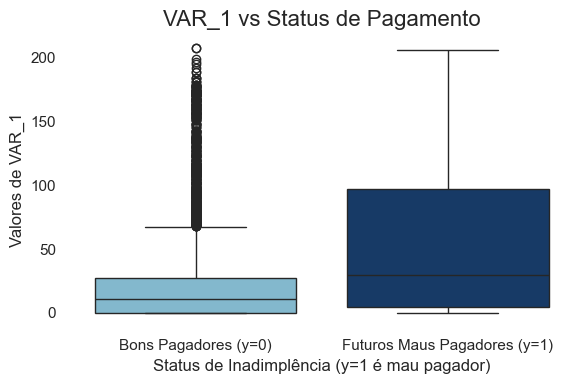

In [17]:
# --- Parâmetros básicos
VAR      = "VAR_1"   # variável explicativa (dias de atraso, por ex.)
TARGET   = "y"       # target binário
THRESH   = 90
PALETTE  = ['#77BDD9', '#0A3873']  # y=0, y=1
coluna   = VAR  # usado para o título do boxplot

# --- Análise de causalidade temporal
mask  = raw_data[VAR] >= THRESH
total = mask.sum()
rate  = raw_data.loc[mask, TARGET].mean() * 100 if total else 0.0

print("=" * 60)
print(f"📌 Verificação de causalidade temporal entre '{VAR}' e '{TARGET}'")
print("=" * 60)
print(f"📄 Total de registros com {VAR} ≥ {THRESH} dias: {total:,}")
print(f"🎯 Taxa de eventos ({TARGET}=1) entre esses casos: {rate:.2f}%\n")

if total == 0:
    print("⚠️  Nenhum registro atende ao critério; análise inconclusiva.")
elif abs(rate - 100.0) < 1e-6:
    print("❌ Conclusão: Todos os registros com "
          f"{VAR} ≥ {THRESH} dias têm {TARGET} = 1, "
          "indicando que a variável é consequência (pós‑evento) do target.")
else:
    print("✅ Conclusão: Como nem todos os casos com "
          f"{VAR} ≥ {THRESH} dias têm {TARGET} = 1,\n"
          "presume‑se que 'y' representa inadimplência futura (a ser observada após a data atual).\n"
          f"Ou seja, {VAR} é uma variável explicativa (pré‑evento) e não consequência de {TARGET}.")

# --- Gráfico: Boxplot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.boxplot(
    x=TARGET,
    y=coluna,
    data=raw_data,
    palette=PALETTE,
    ax=ax
)

ax.set_title(f'{coluna} vs Status de Pagamento', fontsize=16)
ax.set_xlabel('Status de Inadimplência (y=1 é mau pagador)', fontsize=12)
ax.set_ylabel(f'Valores de {coluna}', fontsize=12)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Bons Pagadores (y=0)', 'Futuros Maus Pagadores (y=1)'], fontsize=11)
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


### Volumetria de Contratos e Taxa de Inadimplência por Safra de Originação

In [18]:
def plot_safra_e_target(
    df,
    id_col='id',
    safra_col='safra',
    target_col='y',
    y1_range=None,
    y2_range=None
):
    df = df.copy()

    # 1) Conversão e ordenação
    df[safra_col] = pd.to_datetime(df[safra_col].astype(str), format='%Y%m')
    df = df.sort_values(by=safra_col)
    df['safra_str'] = df[safra_col].dt.strftime('%Y-%m')

    # 2) Agregação
    resumo = (
        df.groupby('safra_str', sort=False)
          .agg(qtd_contratos=(id_col, 'count'),
               pct_inadimplencia=(target_col, 'mean'))
          .reset_index()
    )
    resumo['pct_inadimplencia'] *= 100

    # 3) Hovertemplates sem repetições
    hover_bar = '<b>Qtd. Contratos:</b> %{y:,}<extra></extra>'
    hover_line = '<b>% Target (y):</b> %{y:.2f}%<extra></extra>'

    # 4) Gráfico
    fig = go.Figure()

    # Barras – quantidade de contratos
    fig.add_trace(go.Bar(
        x=resumo['safra_str'],
        y=resumo['qtd_contratos'],
        name='Qtd. Contratos',
        marker_color='silver',
        yaxis='y1',
        hovertemplate=hover_bar
    ))

    # Linha – % target
    fig.add_trace(go.Scatter(
        x=resumo['safra_str'],
        y=resumo['pct_inadimplencia'],
        name='% Target (y)',
        mode='lines+markers',
        line=dict(color='#11BF5D', width=2.5),
        marker=dict(color='#11BF5D', size=6),
        yaxis='y2',
        hovertemplate=hover_line
    ))

    # 5) Layout
    fig.update_layout(
        title='Evolução de Novos Contratos e Taxa de Inadimplência Futura por Safra',
        template='plotly_white',
        height=500,
        hovermode='x unified',
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(0,0,0,0)'),

        xaxis=dict(
            title='Safra (Ano‑Mês)',
            tickmode='array',
            tickvals=resumo['safra_str'],
            ticktext=resumo['safra_str'],
            tickangle=-45
        ),
        yaxis=dict(
            title='Qtd. Contratos',
            side='left',
            showgrid=False,
            range=y1_range
        ),
        yaxis2=dict(
            title='% Target (y)',
            side='right',
            overlaying='y',
            showgrid=False,
            tickformat=".1f",
            range=y2_range
        )
    )

    fig.show()

plot_safra_e_target(
    raw_data,
    y1_range=[0, 1000],
    y2_range=[0, 50]
)

In [19]:
from scipy.stats import shapiro, levene, f_oneway, kruskal
from IPython.display import display, Markdown

def avaliar_discriminacao_numerica_por_target(data, target='y', alpha=0.05, detalhar=True):
    num_cols = data.select_dtypes(include=[np.number]).columns
    features = [col for col in num_cols if col != target]
    grupos = data[target].unique()

    def log_markdown(msg):
        if detalhar:
            display(Markdown(msg))

    log_markdown(f"## 🧪 Análise Estatística por Grupos de `{target}`")
    log_markdown(f"**α (nível de significância):** {alpha:.2%}")

    # Armazenar resultados
    resumo = []

    for feature in features:
        # Teste de Shapiro-Wilk por grupo
        shapiro_pvals = []
        for g in grupos:
            try:
                stat, pval = shapiro(data[data[target] == g][feature].dropna())
                shapiro_pvals.append(pval)
            except:
                shapiro_pvals.append(1.0)  # Assume normal se erro
        normalidade = all(p > alpha for p in shapiro_pvals)
        p_shapiro_mean = np.mean(shapiro_pvals)

        # Teste de Levene
        grupos_data = [data[data[target] == g][feature].dropna() for g in grupos]
        try:
            stat_levene, p_levene = levene(*grupos_data)
            homogeneidade = p_levene > alpha
        except:
            homogeneidade = False
            p_levene = np.nan

        # Escolha do teste
        if normalidade and homogeneidade:
            try:
                stat_anova, p_anova = f_oneway(*grupos_data)
                p_final = p_anova
                teste = "ANOVA"
                conclusao = "✅ Diferença significativa" if p_anova < alpha else "🟦 Sem evidência"
            except:
                p_final = np.nan
                teste = "ANOVA (erro)"
                conclusao = "⚠️ Erro na ANOVA"
        else:
            try:
                stat_kw, p_kw = kruskal(*grupos_data)
                p_final = p_kw
                teste = "Kruskal-Wallis"
                conclusao = "✅ Diferença significativa" if p_kw < alpha else "🟦 Sem evidência"
            except:
                p_final = np.nan
                teste = "Kruskal-Wallis (erro)"
                conclusao = "⚠️ Erro no Kruskal"

        # Guardar no resumo
        resumo.append({
            'feature': feature,
            'normalidade': "✅" if normalidade else "❌",
            'p_shapiro_mean': round(p_shapiro_mean, 4),
            'homogeneidade': "✅" if homogeneidade else "❌",
            'p_levene': round(p_levene, 4) if not np.isnan(p_levene) else 'erro',
            'teste_usado': teste,
            'p_final': round(p_final, 4) if not np.isnan(p_final) else 'erro',
            'conclusao': conclusao
        })

        # Detalhamento por feature
        msg = f"""
---  
### 🔍 Feature: `{feature}`  
- 🔎 **Normalidade (Shapiro-Wilk):** {"✅" if normalidade else "❌"} (p-média: {p_shapiro_mean:.3f})  
- 📏 **Homogeneidade (Levene):** {"✅" if homogeneidade else "❌"} (p: {p_levene:.3f})  
- 🧮 **Teste aplicado:** `{teste}`  
- 📊 **p-valor final:** {p_final:.4f}  
- 🧠 **Conclusão:** **{conclusao}**  
        """
        log_markdown(msg)

    # Mostrar resumo final
    resumo_df = pd.DataFrame(resumo).set_index('feature')
    display(Markdown("## 📋 Resumo Comparativo Final"))
    display(resumo_df.style.highlight_between(subset=['p_final'], left=0, right=alpha, color='#4d4d4d'))

    return resumo_df

resumo = avaliar_discriminacao_numerica_por_target(raw_data.drop(columns=['id', 'safra']), target='y', detalhar=False)

## 📋 Resumo Comparativo Final

,normalidade,p_shapiro_mean,homogeneidade,p_levene,teste_usado,p_final,conclusao
feature,,,,,,,
VAR_1,❌,0.000000,❌,0.000000,Kruskal-Wallis,0.000000,✅ Diferença significativa
VAR_2,❌,0.000000,❌,0.000000,Kruskal-Wallis,0.000000,✅ Diferença significativa
VAR_3,❌,0.000000,❌,0.000000,Kruskal-Wallis,0.000000,✅ Diferença significativa
VAR_4,❌,0.000000,❌,0.000000,Kruskal-Wallis,0.000000,✅ Diferença significativa
VAR_5,❌,0.000000,✅,0.063900,Kruskal-Wallis,0.303600,🟦 Sem evidência
VAR_6,❌,0.000000,❌,0.005500,Kruskal-Wallis,0.000000,✅ Diferença significativa
VAR_7,❌,0.000000,✅,0.895900,Kruskal-Wallis,0.076300,🟦 Sem evidência
VAR_8,❌,0.000000,✅,0.297000,Kruskal-Wallis,0.000200,✅ Diferença significativa
VAR_9,❌,0.000000,❌,0.001000,Kruskal-Wallis,0.000000,✅ Diferença significativa


## Seção 3 – Análise Univariada

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def plot_vif(df, threshold=15.0):
    """
    Calcula e plota os VIFs das variáveis numéricas de um DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame com apenas variáveis numéricas.
        threshold (float): Limite a partir do qual o VIF será destacado em laranja.
    """
    # --- 1. Preparo dos dados: remove NAs e constantes ---
    X = df.dropna().copy()
    X = X.loc[:, X.std() > 0]  # remove colunas constantes (std = 0)

    # Evita erro se restar menos de 2 colunas
    if X.shape[1] < 2:
        print("⚠️ Número insuficiente de variáveis com variância não nula.")
        return

    # --- 2. Calcular VIF ---
    vif_values = []
    for i in range(X.shape[1]):
        try:
            vif = variance_inflation_factor(X.values, i)
        except:
            vif = np.inf
        vif_values.append(vif)

    vif_data = pd.DataFrame({
        'feature': X.columns,
        'VIF': vif_values
    }).sort_values(by='VIF', ascending=True)

    # --- 3. Plotando barra a barra com cores personalizadas ---
    plt.figure(figsize=(8, max(4, len(vif_data)*0.4)))

    for i, row in enumerate(vif_data.itertuples()):
        color = '#F28E2B' if row.VIF > threshold else '#B0B0B0'
        plt.barh(
            y=i,
            width=row.VIF,
            color=color,
            edgecolor='black'
        )
        
        # ✅ Adiciona rótulo apenas se valor for finito
        if np.isfinite(row.VIF):
            plt.text(row.VIF + 0.2, i, f'{row.VIF:.1f}', va='center', fontsize=9)


    # --- 4. Eixos e estética ---
    plt.yticks(ticks=range(len(vif_data)), labels=vif_data['feature'])
    plt.axvline(threshold, color='#F28E2B', linestyle='--', lw=1.3, label=f'Threshold = {threshold}')
    plt.xlabel('VIF')
    plt.title('🔍 VIF por Feature (Multicolinearidade)')
    plt.legend(loc='lower right')
    plt.grid(False)
    plt.box(False)
    plt.tight_layout()
    plt.show()

    return vif_data


In [21]:
from catboost import CatBoostClassifier, Pool
from scipy.stats import spearmanr, pointbiserialr
from sklearn.utils.class_weight import compute_sample_weight

def smart_drop_missing(
    df: pd.DataFrame,
    target_col: str,
    base_missing_thr: float = 0.60,
    min_importance: float = 0.005,
    min_corr: float = 0.02,
    small_ds_boost: float = 0.10,
    sample_weight: np.ndarray = None,
    random_state: int = 42,
    verbose: bool = True,
):
    # 1. Separação X e y
    y = df[target_col].values
    X = df.drop(columns=[target_col])

    # 2. Percentual de missing por coluna
    miss_pct = X.isna().mean()

    # 3. Correlação com o target
    corr = {}
    for col in X.columns:
        try:
            if pd.api.types.is_numeric_dtype(X[col]):
                rho, _ = spearmanr(X[col], y, nan_policy="omit")
            else:
                rho, _ = pointbiserialr(y, X[col].astype("category").cat.codes)
            corr[col] = abs(rho) if np.isfinite(rho) else 0.0
        except:
            corr[col] = 0.0
    corr = pd.Series(corr)

    # 4. Ajuste do limiar de missing
    missing_thr = base_missing_thr - small_ds_boost if len(df) < 10_000 else base_missing_thr

    # 5. Colunas categóricas para o CatBoost (opcionalmente detectadas)
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # 6. Treinamento do CatBoost
    if sample_weight is None:
        sample_weight = compute_sample_weight('balanced', y)

    train_pool = Pool(data=X, label=y, weight=sample_weight, cat_features=cat_cols)

    model = CatBoostClassifier(
        iterations=200,
        depth=4,
        learning_rate=0.05,
        random_state=random_state,
        verbose=False
    )
    model.fit(train_pool)

    # 7. Importância das features
    imp_vals = model.get_feature_importance(train_pool, type='FeatureImportance')
    imp = pd.Series(data=imp_vals, index=X.columns)
    imp = imp / imp.sum() if imp.sum() > 0 else imp

    # 8. Lógica de exclusão
    to_drop = (
        (miss_pct > missing_thr) &
        (imp < min_importance) &
        (corr < min_corr)
    )
    dropped_cols = to_drop[to_drop].index.tolist()
    kept_cols = to_drop[~to_drop].index.tolist()

    # 9. Logs
    if verbose:
        print("🔍 Critérios de exclusão:")
        print(f"  • missing > {missing_thr:.0%}")
        print(f"  • importância < {min_importance:.3f}")
        print(f"  • |correlação| < {min_corr:.3f}")
        print(f"\n🗑️  Colunas removidas ({len(dropped_cols)}):")
        for col in dropped_cols:
            print(f"   - {col:20s}  missing={miss_pct[col]:.1%}  imp={imp[col]:.3f}  |ρ|={corr[col]:.3f}")
        print(f"\n✅ Colunas mantidas ({len(kept_cols)})")

    # 10. Estatísticas finais
    stats = pd.DataFrame({
        'missing_pct': miss_pct,
        'importance': imp,
        'abs_corr': corr,
        'dropped': to_drop
    }).sort_values(by='missing_pct', ascending=False)

    return df.drop(columns=dropped_cols), stats

sample_weights = compute_sample_weight('balanced', y=raw_data['y'])

df_cleaned, stats_vazios = smart_drop_missing(
    df=raw_data.drop(columns=['id', 'safra']),
    target_col='y',
    base_missing_thr=0.30,
    min_importance=0.010,
    sample_weight=sample_weights,
    min_corr=0.05,
    verbose=True
)

# Remoção posterior com condição adicional
df = df_cleaned[df_cleaned['VAR_1'] < 90]

🔍 Critérios de exclusão:
  • missing > 30%
  • importância < 0.010
  • |correlação| < 0.050

🗑️  Colunas removidas (28):
   - VAR_5                 missing=37.8%  imp=0.002  |ρ|=0.013
   - VAR_7                 missing=43.1%  imp=0.001  |ρ|=0.023
   - VAR_8                 missing=45.0%  imp=0.001  |ρ|=0.048
   - VAR_10                missing=51.8%  imp=0.001  |ρ|=0.014
   - VAR_11                missing=46.4%  imp=0.002  |ρ|=0.017
   - VAR_12                missing=67.0%  imp=0.002  |ρ|=0.026
   - VAR_13                missing=48.6%  imp=0.000  |ρ|=0.014
   - VAR_15                missing=47.1%  imp=0.003  |ρ|=0.024
   - VAR_16                missing=66.2%  imp=0.005  |ρ|=0.035
   - VAR_24                missing=37.8%  imp=0.004  |ρ|=0.003
   - VAR_35                missing=46.4%  imp=0.002  |ρ|=0.021
   - VAR_38                missing=43.1%  imp=0.003  |ρ|=0.036
   - VAR_39                missing=48.6%  imp=0.001  |ρ|=0.011
   - VAR_43                missing=67.0%  imp=0.002  |ρ|=0.0

In [22]:
# 📊 Análise de Dados Ausentes
missing = (df.isna().mean() * 100).sort_values(ascending=False)
total_missing = (missing > 0).sum()

print("\n" + "="*60)
print(f"🔍 Foram encontradas {total_missing} colunas com dados ausentes.")
print("🧮 Percentual de valores ausentes por coluna:")
print("="*60 + "\n")

missing = missing.to_frame('pct_missing').reset_index()

display(missing.head(100))


🔍 Foram encontradas 40 colunas com dados ausentes.
🧮 Percentual de valores ausentes por coluna:



,index,pct_missing
0,VAR_70,77.451949
1,VAR_61,72.070291
2,VAR_49,68.500824
3,VAR_36,68.303130
4,VAR_47,67.029105
5,VAR_21,66.831411
6,VAR_18,66.831411
7,VAR_41,65.864909
8,VAR_68,62.053817
9,VAR_48,60.131796


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from lightgbm import LGBMRegressor

def permutation_test(original: np.ndarray, imputed: np.ndarray, n_permutations: int = 1000, random_state: int | None = None) -> float:
    rng = np.random.default_rng(random_state)
    pooled = np.concatenate([original, imputed])
    observed_diff = np.mean(imputed) - np.mean(original)
    count, len_original = 0, len(original)
    for _ in range(n_permutations):
        permuted = rng.permutation(pooled)
        perm_diff = np.mean(permuted[len_original:]) - np.mean(permuted[:len_original])
        if np.abs(perm_diff) >= np.abs(observed_diff):
            count += 1
    return count / n_permutations

class AdaptiveImputer(BaseEstimator, TransformerMixin):
    """
    Realiza a imputação adaptativa e validada de dados ausentes em um DataFrame.

    Esta classe foi projetada para ser uma solução robusta e inteligente de
    pré-processamento, combinando múltiplas estratégias para tratar valores
    ausentes de forma eficiente e segura.

    O seu modo de operação é dividido em três pilares principais:
    1.  **Estratégia Adaptativa**: Decide entre uma imputação simples (mediana) ou
        uma multivariada avançada (usando IterativeImputer com LGBMRegressor) com
        base no percentual de dados ausentes de cada coluna.
    2.  **Imputação Vigiada**: Garante que os valores imputados não extrapolem os
        limites observados nos dados originais (mínimo e máximo), prevenindo a
        criação de valores absurdos.
    3.  **Validação Estatística**: Executa um teste de permutação não paramétrico
        para verificar se a distribuição dos valores imputados é estatisticamente
        semelhante à dos valores originais. Se uma imputação for considerada
        ruim, ela é revertida.

    Parameters
    ----------
    max_missing : float, default=0.60
        Percentual máximo de valores ausentes que uma coluna pode ter para ser
        considerada para imputação. Colunas com mais `NaNs` que este limite
        serão ignoradas e mantidas com seus valores ausentes.
    switch_threshold : float, default=0.001
        Limite de percentual de `NaNs` que define a estratégia de imputação.
        - Se `0 < %NaN <= switch_threshold`: usa imputação simples (mediana).
        - Se `%NaN > switch_threshold`: usa imputação avançada (IterativeImputer).
    target_col : str | None, default=None
        Nome da coluna alvo (variável dependente) do modelo. Se fornecida,
        esta coluna será completamente ignorada no processo de imputação.
    bounds : dict | None, default=None
        Dicionário para fornecer limites (mínimo, máximo) manuais para colunas
        específicas. Ex: `{'NOME_COLUNA': (min_val, max_val)}`.
    automatic_bounds : bool, default=False
        Se `True`, calcula automaticamente os limites para cada coluna com base
        nos valores mínimo e máximo observados nos dados de treino. Estes
        limites são usados para restringir os valores imputados.
    perm_alpha : float, default=0.10
        Nível de significância (alfa) para o teste de permutação. Se o p-valor
        do teste for menor que `perm_alpha`, a imputação da coluna é
        considerada estatisticamente diferente da original e será revertida.
    n_permutations : int, default=1000
        Número de permutações a serem realizadas no teste estatístico para
        cálculo do p-valor.
    random_state : int, default=42
        Semente para os geradores de números aleatórios, garantindo a
        reprodutibilidade dos resultados do `LGBMRegressor`, `IterativeImputer`
        e do teste de permutação.
    verbose : bool, default=False
        Se `True`, imprime logs sobre as ações realizadas, como clipping,
        colunas revertidas e o relatório do teste de permutação.
    exclude_cols : list[str] | None, default=None
        Lista de nomes de colunas a serem completamente ignoradas durante
        todo o processo de imputação.

    Atributos
    ---------
    pipeline_ : ColumnTransformer
        O pipeline do Scikit-learn treinado que contém os imputers.
    bounds_ : dict
        Dicionário final com os limites (mínimo, máximo) a serem aplicados.
    failed_cols_ : list
        Lista de colunas cuja imputação falhou no teste de permutação e
        foi revertida.
    report_ : pd.DataFrame
        DataFrame com um relatório detalhado das ações tomadas para cada coluna.
    test_report_ : pd.DataFrame
        DataFrame com os p-valores das colunas que passaram no teste de permutação.
    """
    
    def __init__(self,
                 max_missing: float = 0.60,
                 switch_threshold: float = 0.001,
                 target_col: str | None = None,
                 bounds: dict | None = None,
                 automatic_bounds: bool = False,
                 perm_alpha: float = 0.05,
                 n_permutations: int = 1000,
                 random_state: int = 42,
                 verbose: bool = False,
                 exclude_cols: list[str] | None = None
                 ):
        self.max_missing = max_missing
        self.switch_threshold = switch_threshold
        self.target_col = target_col
        self.bounds = bounds or {}
        self.automatic_bounds = automatic_bounds
        self.perm_alpha = perm_alpha
        self.n_permutations = n_permutations
        self.random_state = random_state
        self.verbose = verbose
        self.exclude_cols = exclude_cols or []

    def fit(self, X: pd.DataFrame, y=None):
            X_fit = X.copy()

            # 1. Definir colunas a serem processadas
            numeric_cols = X_fit.select_dtypes(include="number").columns.tolist()
            excluded = (self.exclude_cols or []) + ([self.target_col] if self.target_col else [])
            self.impute_cols_ = [c for c in numeric_cols if c not in excluded]

            miss_pct = X_fit[self.impute_cols_].isna().mean()
            self.cols_to_drop_ = miss_pct[miss_pct > self.max_missing].index.tolist()
            self.impute_cols_ = [c for c in self.impute_cols_ if c not in self.cols_to_drop_]
            
            self.actual_impute_cols_ = miss_pct[miss_pct > 0].index.tolist()
            self.actual_impute_cols_ = [c for c in self.actual_impute_cols_ if c in self.impute_cols_]

            if not self.actual_impute_cols_:
                self.imputer_ = None
                self.failed_cols_ = []
                # Mesmo sem imputação, o relatório deve ser criado
                self.report_ = pd.DataFrame({"missing_pct": miss_pct, "action": "no_missing"}).reset_index().rename(columns={"index": "column"})
                return self

            # 2. Definir e treinar o imputer
            self.imputer_ = IterativeImputer(
                estimator=LGBMRegressor(random_state=self.random_state, n_jobs=-1, verbose=-1),
                max_iter=10, random_state=self.random_state
            )
            self.imputer_.fit(X_fit[self.impute_cols_])

            # 3. Simular imputação para validação
            X_imputed_test = self._impute_and_clip(X_fit)
            
            # 4. Validar com Teste de Permutação
            self.failed_cols_ = []
            test_pass_data = {}
            for col in self.actual_impute_cols_:
                mask_nan = X_fit[col].isna()
                original_values = X_fit.loc[~mask_nan, col].values
                imputed_values  = X_imputed_test.loc[mask_nan, col].values
                p_value = permutation_test(original_values, imputed_values, n_permutations=self.n_permutations, random_state=self.random_state)
                if p_value < self.perm_alpha:
                    self.failed_cols_.append(col)
                else:
                    test_pass_data[col] = {"p_value": p_value}
            self.test_report_ = pd.DataFrame(test_pass_data).T

            # --- CORREÇÃO: Bloco que cria self.report_ foi reinserido ---
            # 5. Geração do relatório de ações
            def _action(c):
                if c in self.cols_to_drop_: return "drop"
                if c not in self.impute_cols_: return "ignore"
                if c in self.failed_cols_: return "impute_fail"
                if c in self.actual_impute_cols_: return "iterative"
                return "no_missing"

            self.report_ = pd.DataFrame({
                "action": [_action(c) for c in X_fit.columns]
            })
            self.report_['column'] = X_fit.columns
            # ----------------------------------------------------------------

            if self.verbose:
                print(f"Colunas a serem imputadas: {self.actual_impute_cols_}")
                if self.failed_cols_: print(f"⚠️ Imputação revertida para: {self.failed_cols_}")
                if not self.test_report_.empty:
                    print("\n✅ Permutation Test (aprovados):")
                    print(self.test_report_)
            return self

    def _impute_and_clip(self, X: pd.DataFrame) -> pd.DataFrame:
        """Helper para imputar e aplicar clip, usado em fit e transform."""
        X_processed = X.copy()
        imputable_subset = X_processed[self.impute_cols_]

        # Realiza a imputação
        imputed_array = self.imputer_.transform(imputable_subset)
        X_imputed = pd.DataFrame(imputed_array, columns=self.impute_cols_, index=imputable_subset.index)

        # Aplica o clip apenas nos valores que eram NaN
        for col in self.actual_impute_cols_:
            mask_nan = X[col].isna()
            min_val = X[col].min()
            max_val = X[col].max()
            X_imputed.loc[mask_nan, col] = np.clip(X_imputed.loc[mask_nan, col], min_val, max_val)

        # Atualiza o DataFrame original com os valores imputados e clipados
        X_processed[self.impute_cols_] = X_imputed
        return X_processed

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if not hasattr(self, 'imputer_') or self.imputer_ is None:
            return X # Nenhuma imputação foi treinada, retorna o original

        # Imputa e aplica o clip
        X_final = self._impute_and_clip(X)
        
        # Reverte colunas que falharam na validação do fit
        if self.failed_cols_:
            X_final[self.failed_cols_] = X[self.failed_cols_]
            
        return X_final

    def plot_reduction(self, X_original: pd.DataFrame, X_imputed: pd.DataFrame, 
                        method: str = 'pca', sample_size: int = 2000):
            """
            Plota a redução de dimensionalidade dos dados antes e depois da imputação,
            garantindo que ambos os gráficos usem a mesma escala de eixos para uma 
            comparação visual justa.

            Args:
                X_original (pd.DataFrame): O DataFrame original antes da imputação.
                X_imputed (pd.DataFrame): O DataFrame resultante após a imputação.
                method (str): Técnica de redução: 'pca', 'kernelpca', 'tsne'.
                sample_size (int): Tamanho da amostra para plotagem para evitar lentidão.
            """
            if not hasattr(self, 'report_'):
                print("O imputer precisa ser treinado primeiro (`fit` ou `fit_transform`).")
                return

            imputed_cols = self.report_[self.report_['action'].isin(['simple', 'iterative'])]['column'].tolist()
            if not imputed_cols:
                print("Nenhuma coluna foi imputada. Não há o que plotar.")
                return

            n_samples = min(sample_size, len(X_original))
            if n_samples > 0:
                sample_idx = np.random.choice(X_original.index, size=n_samples, replace=False)
            else:
                print("Não há dados suficientes para plotar.")
                return

            df_orig = X_original.loc[sample_idx, imputed_cols].copy()
            df_imputed = X_imputed.loc[sample_idx, imputed_cols].copy()

            missing_mask_any = df_orig.isna().any(axis=1)
            status = np.where(missing_mask_any, 'Ponto Ausente', 'Ponto Observado')

            df_orig_filled = df_orig.fillna(df_orig.median())

            scaler = StandardScaler().fit(df_orig_filled)
            X_orig_scaled = scaler.transform(df_orig_filled)
            X_imputed_scaled = scaler.transform(df_imputed)

            reducers = {
                'pca': PCA(n_components=2, random_state=self.random_state),
                'kernelpca': KernelPCA(n_components=2, kernel='rbf', random_state=self.random_state, n_jobs=-1),
                'tsne': TSNE(n_components=2, random_state=self.random_state, n_jobs=-1)
            }
            reducer = reducers.get(method.lower())
            if reducer is None:
                print(f"Método '{method}' não suportado. Escolha entre 'pca', 'kernelpca', 'tsne'.")
                return

            # --- CORREÇÃO 1: Treinar o redutor apenas uma vez ---
            # Treina o redutor com os dados originais para definir o espaço de projeção.
            reducer.fit(X_orig_scaled)
            
            # Transforma ambos os datasets usando o MESMO redutor treinado.
            X_orig_reduced = reducer.transform(X_orig_scaled)
            X_imputed_reduced = reducer.transform(X_imputed_scaled)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7)) # sharey removido para controle manual
            sns.set_style("whitegrid")
            palette = {'Ponto Observado': 'royalblue', 'Ponto Ausente': 'orangered'}

            # Gráfico "Antes"
            sns.scatterplot(x=X_orig_reduced[:, 0], y=X_orig_reduced[:, 1], hue=status, 
                            palette=palette, ax=ax1, alpha=0.7)
            ax1.set_title(f'Antes da Imputação ({method.upper()})', fontsize=14)
            ax1.set_xlabel('Componente 1')
            ax1.set_ylabel('Componente 2')
            ax1.legend(title='Status Original')

            # Gráfico "Depois"
            sns.scatterplot(x=X_imputed_reduced[:, 0], y=X_imputed_reduced[:, 1], hue=status, 
                            palette=palette, ax=ax2, alpha=0.7)
            ax2.set_title(f'Depois da Imputação ({method.upper()})', fontsize=14)
            ax2.set_xlabel('Componente 1')
            ax2.set_ylabel('') # Remove o label y do segundo gráfico para limpar a visualização
            ax2.get_legend().remove()
            
            # --- CORREÇÃO 2: Forçar a mesma escala nos eixos ---
            # Concatena todos os pontos para encontrar os limites globais
            all_points = np.concatenate([X_orig_reduced, X_imputed_reduced], axis=0)
            
            # Calcula os limites com uma margem de 5%
            x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
            y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
            x_margin = (x_max - x_min) * 0.05
            y_margin = (y_max - y_min) * 0.05
            
            # Aplica os mesmos limites a ambos os gráficos
            ax1.set_xlim(x_min - x_margin, x_max + x_margin)
            ax2.set_xlim(x_min - x_margin, x_max + x_margin)
            ax1.set_ylim(y_min - y_margin, y_max + y_margin)
            ax2.set_ylim(y_min - y_margin, y_max + y_margin)
            
            plt.suptitle(f'Visualização do Impacto da Imputação com {method.upper()}', fontsize=16, y=1.02)
            plt.tight_layout()
            plt.show()

In [ ]:
# 1. Instancia o imputer
imp = AdaptiveImputer(
    max_missing=0.40,
    switch_threshold=0.01,
    perm_alpha=0.05,
    exclude_cols=["id", "safra"],
    automatic_bounds=True,
    verbose=True
)

# 2. Treina o imputer e transforma os dados
print("--- Iniciando treinamento do imputer ---")
clean_df = imp.fit_transform(df)
print("\n--- Treinamento concluído ---")

# 3. Plota os resultados usando o imputer recém-treinado
print("\n--- Gerando visualizações ---")
imp.plot_reduction(df, clean_df, method='pca')
#imp.plot_reduction(df, clean_df, method='tsne')

--- Iniciando treinamento do imputer ---


In [29]:
report = imp.report_
colunas_aprovadas = report[report['action'].isin(['simple','interactive'])]['column'].tolist()

print(f"{'Coluna':<10} | {'Nulos(orig)':<12} | {'Nulos(limp)':<12} | {'Média(orig)':<12} | {'Média(limp)':<12} | {'Mediana(orig)':<14} | {'Mediana(limp)':<14} | {'Min(orig)':<10} | {'Min(limp)':<10} | {'Max(orig)':<10} | {'Max(limp)':<10}")
print('-' * 140)

# Linhas
for col in colunas_aprovadas: 
    nulos_orig = df[col].isna().sum()
    nulos_limp = clean_df[col].isna().sum()
    
    media_orig = df[col].mean()
    media_limp = clean_df[col].mean()
    
    mediana_orig = df[col].median()
    mediana_limp = clean_df[col].median()
    
    min_orig = df[col].min()
    min_limp = clean_df[col].min()
    
    max_orig = df[col].max()
    max_limp = clean_df[col].max()

    print(f"{col:<10} | {nulos_orig:<12} | {nulos_limp:<12} | {media_orig:<12.2f} | {media_limp:<12.2f} | {mediana_orig:<14.2f} | {mediana_limp:<14.2f} | {min_orig:<10.2f} | {min_limp:<10.2f} | {max_orig:<10.2f} | {max_limp:<10.2f}")


AttributeError: 'AdaptiveImputer' object has no attribute 'report_'

In [26]:
col='VAR_6'
pd.concat([df[df[col].isna()][[col]], clean_df[clean_df[col].isna()][[col]]],axis=1)

,VAR_6,VAR_6
57,NaN,NaN
1115,NaN,NaN
1950,NaN,NaN
2595,NaN,NaN
2905,NaN,NaN
3219,NaN,NaN
4624,NaN,NaN
5106,NaN,NaN
7745,NaN,NaN
7776,NaN,NaN


In [ ]:
eda = CreditRiskEDA(df,
                    "y",
                    numerical_cols,
                    categorical_cols,
                    order_by_iv=True,
                    remove_outliers=True,
                    independent_outlier_removal=True,
                    plot_shap=True
                    )

eda.run()

In [ ]:
def create_orthogonal_features(df: pd.DataFrame, dominant_feature: str, features_to_transform: list) -> pd.DataFrame:
    """Creates orthogonal versions of features removing linear influence of dominant feature."""
    if dominant_feature not in df.columns:
        print(
            f"Dominant feature '{dominant_feature}' not found; skipping orthogonal features."
        )
        return df


    print(
        "Creating orthogonal features with respect to '%s'...", dominant_feature
    )

    temp_df = df[[dominant_feature] + features_to_transform].dropna()
    if temp_df.empty:
        print(
            "DataFrame is empty after dropping NaNs; cannot create orthogonal features."
        )
        return df

    created: list[str] = []
    X_dominant_fit = temp_df[[dominant_feature]]
    for col in features_to_transform:
        if (
            col == dominant_feature
            or col not in df.columns
            or col.startswith("alvo")
        ):
            continue

        y_target = temp_df[col]
        model = LinearRegression()
        model.fit(X_dominant_fit, y_target)

        # Preenchemos os NaNs com 0 apenas para a predição, garantindo que o modelo não falhe.
        predictions = model.predict(df[[dominant_feature]].fillna(0))

        residuals = df[col] - predictions

        new_col_name = f"{col}_ortho_{dominant_feature}"
        df[new_col_name] = residuals
        created.append(new_col_name)

    if created:
        print("Created %d orthogonal features.", len(created))
    else:
        print("No orthogonal features created.")

    return df

In [ ]:
import xgboost as xgb
import shap
from sklearn.linear_model import LinearRegression
from sklearn.utils.class_weight import compute_sample_weight
from tqdm.auto import tqdm # Para uma barra de progresso amigável

# =============================================================================
# 1. FUNÇÃO AUXILIAR PARA CRIAR A FEATURE ORTOGONAL
# =============================================================================
def create_orthogonal_feature(df: pd.DataFrame, dominant_feature: str, feature_to_transform: str) -> pd.DataFrame:
    """
    Cria uma versão ortogonal de uma feature, removendo a influência linear de uma feature dominante.

    Args:
        df (pd.DataFrame): DataFrame contendo os dados.
        dominant_feature (str): Nome da coluna da feature dominante.
        feature_to_transform (str): Nome da coluna da feature a ser transformada.

    Returns:
        pd.DataFrame: DataFrame com a nova coluna ortogonal adicionada.
    """
    df_temp = df[[dominant_feature, feature_to_transform]].dropna()
    
    # Se não houver dados suficientes para a regressão, retorna o df original
    if df_temp.shape[0] < 2:
        return df

    # Modelo de regressão linear para remover a influência da feature dominante
    X_dominant = df_temp[[dominant_feature]]
    y_target = df_temp[feature_to_transform]
    
    model = LinearRegression()
    model.fit(X_dominant, y_target)

    # Preenchemos NaNs com a mediana para a predição, garantindo que o modelo não falhe.
    # Usar a mediana é mais robusto a outliers do que a média.
    dominant_median = df[dominant_feature].median()
    predictions = model.predict(df[[dominant_feature]].fillna(dominant_median))

    # O resíduo é a parte da feature que NÃO é explicada pela dominante
    residuals = df[feature_to_transform] - predictions
    
    new_col_name = f"{feature_to_transform}_ortho_{dominant_feature}"
    df[new_col_name] = residuals
    
    return df

# =============================================================================
# 2. FUNÇÃO PRINCIPAL DO PIPELINE
# =============================================================================

def generate_orthogonal_features_pipeline(
    df: pd.DataFrame, 
    target_col: str, 
    shap_cumulative_threshold: float = 0.8, 
    correlation_threshold: float = 0.3
) -> pd.DataFrame:
    """
    Pipeline completo para identificar features dominantes e gerar features ortogonais.
    """
    print("Iniciando o pipeline de geração de features ortogonais...")
    df_processed = df.copy()

    # --- PASSO 1: Identificar features e tratar NaNs ---
    features_originais = [col for col in df.columns if col not in [target_col, 'id', 'safra'] and not col.startswith('y')]
    
    ### NOVO: Filtrar colunas com variância zero para evitar o warning ###
    numeric_features = df_processed[features_originais].select_dtypes(include=np.number).columns.tolist()
    variances = df_processed[numeric_features].var()
    cols_com_variancia = variances[variances > 0].index.tolist()
    cols_sem_variancia = variances[variances == 0].index.tolist()

    if cols_sem_variancia:
        print(f"\nAVISO: As seguintes colunas foram removidas por terem variância zero: {cols_sem_variancia}")
        # Mantém apenas colunas com variância e as que não são numéricas (ex: categorias)
        non_numeric_cols = list(set(features_originais) - set(numeric_features))
        features_originais = cols_com_variancia + non_numeric_cols
    
    # Preenchendo com a mediana, que é mais robusta a outliers
    df_filled = df_processed[features_originais].fillna(df_processed[features_originais].median())
    X = df_filled
    y = df_processed[target_col]

    # --- PASSO 2: Treinar XGBoost com sample_weights para obter SHAP values ---
    print("\n[1/4] Treinando modelo XGBoost para calcular a importância (SHAP)...")
    sample_weights = compute_sample_weight(class_weight='balanced', y=y)
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42
    )
    xgb_model.fit(X, y, sample_weight=sample_weights)

    # --- PASSO 3: Calcular SHAP e encontrar features dominantes ---
    print("[2/4] Calculando SHAP values...")
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X)
    
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    shap_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': mean_abs_shap
    }).sort_values('importance', ascending=False)
    
    shap_importance['cumulative_importance_ratio'] = shap_importance['importance'].cumsum() / shap_importance['importance'].sum()
    dominant_features = shap_importance[shap_importance['cumulative_importance_ratio'] <= shap_cumulative_threshold]['feature'].tolist()
    
    if not dominant_features:
        dominant_features = [shap_importance.iloc[0]['feature']]

    print(f"\nFeatures dominantes selecionadas: {dominant_features}")

    # --- PASSO 4: Loop para criar features ortogonais ---
    print("\n[3/4] Gerando features ortogonais...")
    created_ortho_features = set()

    for dominant in tqdm(dominant_features, desc="Processando features dominantes"):
        # Agora o corrwith só será chamado com colunas que têm variância
        correlations = df_processed[features_originais].corrwith(df_processed[dominant]).abs()
        
        features_to_transform = correlations[correlations > correlation_threshold].index.tolist()
        
        for feature_to_tx in features_to_transform:
            if (feature_to_tx != dominant and 
                feature_to_tx != target_col and
                feature_to_tx not in dominant_features and
                feature_to_tx not in created_ortho_features):

                df_processed = create_orthogonal_feature(df_processed, dominant, feature_to_tx)
                new_feature_name = f"{feature_to_tx}_ortho_{dominant}"
                created_ortho_features.add(new_feature_name)
                created_ortho_features.add(feature_to_tx) 
    
    print("\n[4/4] Pipeline concluído!")
    print(f"\nTotal de novas features ortogonais criadas: {len(created_ortho_features)}")
    
    return df_processed

# =============================================================================
# 3. EXECUÇÃO DO PIPELINE
# =============================================================================
if __name__ == '__main__':

    # Executar o pipeline
    df_com_ortho = generate_orthogonal_features_pipeline(
        df=df,
        target_col='y',
        shap_cumulative_threshold=0.8, # Limiar de 80% da importância do SHAP
        correlation_threshold=0.3      # Limiar de correlação de 0.3
    )

    print(f"\nShape do DataFrame Final: {df_com_ortho.shape}")
    
    # Verificando as novas colunas criadas
    novas_colunas = [col for col in df_com_ortho.columns if '_ortho_' in col]
    print("\nAmostra das novas features ortogonais criadas:")
    print(df_com_ortho[novas_colunas].head())

In [ ]:
# --- 1. Detectar variáveis numéricas e categóricas ---
new_numerical_cols, new_categorical_cols = search_dtypes(
    df_com_ortho.drop(columns=['y']),  # remove identificadores e target
    force_categorical=[],                         # permite auto-identificação
    limite_categorico=50,                         # colunas com até 50 valores únicos = categóricas
    verbose=False
)

# --- 2. Exibir resumo organizado ---
display(Markdown("### 📊 Tipos de Variáveis Detectadas"))
print(f"🔢 Variáveis Numéricas: {len(new_numerical_cols)}")
print(f"🔣 Variáveis Categóricas: {len(new_categorical_cols)}")

print("\n🧮 Numéricas:")
print(", ".join(new_numerical_cols[:10]) + ("..." if len(new_numerical_cols) > 10 else ""))

print("\n🔠 Categóricas:")
print(", ".join(new_categorical_cols[:10]) + ("..." if len(new_categorical_cols) > 10 else ""))


In [ ]:

# =============================================================================
# 1. FUNÇÃO DE AVALIAÇÃO E PLOTAGEM (MODIFICADA)
# =============================================================================

def evaluate_and_plot_metrics(model, X, y_true, dataset_name: str):
    """
    Executa a avaliação completa (métricas e plots) para um dado conjunto de dados.

    Args:
        model: O modelo treinado (pipeline).
        X (pd.DataFrame): DataFrame com as features.
        y_true (array-like): Valores verdadeiros do alvo.
        dataset_name (str): Nome do conjunto de dados (ex: "Treino" ou "Teste").
    """
    # Realiza as previsões
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    # Imprime as métricas de classificação
    print("="*60)
    print(f"  Métricas de Avaliação do Modelo - Conjunto de {dataset_name.upper()}")
    print("="*60)
    
    mcc = matthews_corrcoef(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    gini = 2 * auc - 1
    ks = ks_2samp(y_prob[y_true==1], y_prob[y_true==0]).statistic
    
    print(f"MCC (Matthews Correlation Coef): {mcc:.4f}")
    print(f"Precision Score                : {precision:.4f}")
    print(f"AUC (Area Under ROC Curve)     : {auc:.4f}")
    print(f"Gini Coefficient               : {gini:.4f}")
    print(f"KS (Kolmogorov-Smirnov)        : {ks:.4f}")
    print("="*60 + "\n")

    # Plota a Matriz de Confusão
    plot_confusion_matrix(y_true, y_pred, title=f'Matriz de Confusão - {dataset_name}')
    
    # Plota a Curva de Calibração
    plot_calibration_curve(y_true, y_prob, title=f'Curva de Calibração - {dataset_name}')


def plot_confusion_matrix(y_true, y_pred, title='Matriz de Confusão'):
    """Gera e exibe uma matriz de confusão visualmente clara."""
    cm = confusion_matrix(y_true, y_pred)
    group_counts = [f"{value}" for value in cm.flatten()]
    group_percentages = [f"{value:.2%}" for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=True, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('Verdadeiro', fontsize=12)
    ax.set_xlabel('Previsto', fontsize=12)
    ax.xaxis.set_ticklabels(['Classe 0', 'Classe 1'])
    ax.yaxis.set_ticklabels(['Classe 0', 'Classe 1'])
    plt.tight_layout()
    return fig


def plot_calibration_curve(y_true, y_prob, n_bins=10, title='Curva de Calibração'):
    """Plota a curva de calibração e anota o Brier Score."""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    brier = brier_score_loss(y_true, y_prob)
    
    fig, ax = plt.subplots(figsize=(8, 7))
    ax.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Modelo')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibração Perfeita')
    
    ax.text(0.95, 0.05, f'Brier Score: {brier:.4f}', 
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, color='black', fontsize=12,
            bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Probabilidade Média Prevista (por bin)', fontsize=12)
    ax.set_ylabel('Fração de Positivos (por bin)', fontsize=12)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    return fig

In [ ]:
raw_data.safra.min(),raw_data.safra.max()

In [ ]:
# =============================================================================
# 2. PIPELINE DE EXECUÇÃO E AVALIAÇÃO
# =============================================================================
target='y'
features = new_numerical_cols 
X = df_com_ortho[features]
y = df_com_ortho[target]

# --- 2. Divisão dos Dados em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    df_com_ortho.drop('y', axis=1),
    df_com_ortho['y'],
    test_size=0.3,
    random_state=42,
    stratify=y # Importante para manter a proporção no desbalanceamento
)

# --- 3. Tratamento de Features (Simplificado para CatBoost) ---
# O CatBoost não exige pré-processamento para features categóricas.
# Ele também lida bem com features numéricas sem scaling, mas escalar pode ajudar em alguns casos.
# Vamos identificar quais colunas são categóricas para informar ao modelo.
categorical_features_indices = [X_train.columns.get_loc(col) for col in new_categorical_cols]

# --- 4. Cálculo de Pesos ---
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# --- 5. Definição do Modelo CatBoost ---
# Note que não precisamos mais do Pipeline complexo.
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(
    iterations=200,             # Equivalente a n_estimators
    learning_rate=0.05,
    depth=4,                    # Equivalente a max_depth
    subsample=0.8,
    rsm=0.8,                    # Equivalente a colsample_bytree
    loss_function='Logloss',    # Equivalente a objective e eval_metric
    random_seed=42,
    verbose=0,                  # Para não poluir a saída
    cat_features=categorical_features_indices # A MÁGICA ACONTECE AQUI!
)

# --- 6. Treinamento do Modelo ---
print("Iniciando o treinamento do modelo CatBoost...")
# Passamos os pesos da mesma forma
cat_model.fit(X_train, y_train, sample_weight=sample_weights)
print("Treinamento concluído.\n")

# --- 7. AVALIAÇÃO COMPLETA PARA TREINO E TESTE ---
# A função de avaliação funciona perfeitamente com o novo modelo
evaluate_and_plot_metrics(cat_model, X_train, y_train, dataset_name="Treino")
evaluate_and_plot_metrics(cat_model, X_test, y_test, dataset_name="Teste")

# Exibe todos os gráficos gerados
plt.show()


In [ ]:
# --- 1. Detectar variáveis numéricas e categóricas ---
numerical_cols, categorical_cols = search_dtypes(
    df.drop(columns=['y']),  # remove identificadores e target
    force_categorical=[],                         # permite auto-identificação
    limite_categorico=50,                         # colunas com até 50 valores únicos = categóricas
    verbose=False
)

# --- 2. Exibir resumo organizado ---
display(Markdown("### 📊 Tipos de Variáveis Detectadas"))
print(f"🔢 Variáveis Numéricas: {len(numerical_cols)}")
print(f"🔣 Variáveis Categóricas: {len(categorical_cols)}")

print("\n🧮 Numéricas:")
print(", ".join(numerical_cols[:10]) + ("..." if len(numerical_cols) > 10 else ""))

print("\n🔠 Categóricas:")
print(", ".join(categorical_cols[:10]) + ("..." if len(categorical_cols) > 10 else ""))


# =============================================================================
# 2. PIPELINE DE EXECUÇÃO E AVALIAÇÃO
# =============================================================================
target='y'
features = numerical_cols 
X = df[features]
y = df[target]

# --- 2. Divisão dos Dados em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('y', axis=1),
    df['y'],
    test_size=0.3,
    random_state=42,
    stratify=y # Importante para manter a proporção no desbalanceamento
)

# --- 3. Cálculo de Pesos para Amostras Desbalanceadas (apenas com dados de treino)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)


# --- 4. Definição do Pré-processador
# Para as features categóricas, usaremos OneHotEncoder. WoEEncoder não é padrão no scikit-learn.
# Se você tiver seu WoEEncoder, pode substituir 'ohe' por ele.
numeric_features = [col for col in X_train.columns if col.startswith('num')]
categorical_features = [col for col in X_train.columns if col.startswith('cat')]

preprocessor = ColumnTransformer(
    transformers=[
        #('num', StandardScaler(), numeric_features),
        #('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Mantém outras colunas, se houver
)

# --- 5. Definição do Modelo XGBoost
xgb_model = xgb.XGBClassifier(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False, # Recomendado para versões mais novas
    n_jobs=-1,
    random_state=42
)

# --- 6. Criação do Pipeline Final
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# --- 7. Treinamento do Pipeline
# Note como passamos o sample_weight para o passo do classificador
print("\nIniciando o treinamento do pipeline...")
model_pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
print("Treinamento concluído.")

# # --- 8. Realização de Previsões no Conjunto de Teste
# y_pred_test = model_pipeline.predict(X_test)
# y_prob_test = model_pipeline.predict_proba(X_test)[:, 1] # Probabilidade da classe 1

# # --- 9. Avaliação com as Funções de Plotagem
# print("Gerando gráficos de avaliação...")
# fig1 = plot_confusion_matrix(y_test, y_pred_test)
# fig2 = plot_calibration_curve(y_test, y_prob_test)

# plt.show()

# --- 5. AVALIAÇÃO COMPLETA PARA TREINO E TESTE ---
# Avaliação no conjunto de TREINO
evaluate_and_plot_metrics(model_pipeline, X_train, y_train, dataset_name="Treino")

# Avaliação no conjunto de TESTE
evaluate_and_plot_metrics(model_pipeline, X_test, y_test, dataset_name="Teste")

# Exibe todos os gráficos gerados
plt.show()

In [ ]:
# --- 1. Detectar variáveis numéricas e categóricas ---
new_numerical_cols, new_categorical_cols = search_dtypes(
    df_new.drop(columns=['y']),  # remove identificadores e target
    force_categorical=[],        # permite auto-identificação
    limite_categorico=50,        # colunas com até 50 valores únicos = categóricas
    verbose=False
)


eda_new = CreditRiskEDA(df_new,
                    "y",
                    new_numerical_cols,
                    new_categorical_cols,
                    order_by_iv=True,
                    remove_outliers=True,
                    independent_outlier_removal=True,
                    plot_shap=True
                    )

eda_new.run()

In [ ]:
# filtre apenas colunas realmente presentes no DataFrame
num_cols_ok = [c for c in numerical_cols   if c in df.columns]
cat_cols_ok = [c for c in categorical_cols if c in df.columns]


inspector = FeatureRelationshipInspector(
    df         = df,
    target_col = "y",
    num_cols   = num_cols_ok,
    cat_cols   = cat_cols_ok
)

In [ ]:
# 1) PDP para duas variáveis
inspector.plot_pdp(["VAR_1", "VAR_20"])

In [ ]:
# 2) Event‑rate em bins
inspector.plot_event_rate("VAR_1")


In [ ]:
import xgboost as xgb
import shap
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

target='y'
feature = 'VAR_17'
feaures = num_cols_ok 
X = df[feaures]
y = df[target]


print("Calculating sample weights...")
sample_weights = compute_sample_weight(class_weight='balanced', y=y)

print("Training XGBoost model...")
model = xgb.XGBClassifier(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    verbosity=0,
    random_state=42
)

# Fit the model with the calculated sample weights
model.fit(X, y, sample_weight=sample_weights)

# --- Step 4: Calculate SHAP values ---
print("Calculating SHAP values...")
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# --- Step 5: Generate and save the SHAP dependence plot ---
print(f"Generating SHAP dependence plot for {feature}...")
fig, ax = plt.subplots()
shap.plots.scatter(
    shap_values[:, f"{feature}"],
    color=shap_values,
    show=False,
    ax=ax
)
ax.set_title(f"SHAP Dependence Plot for {feature}")
#plt.tight_layout()
plt.show()
#plt.savefig("shap_dependence_plot.png")

#print("\nPlot successfully saved as shap_dependence_plot.png")

In [ ]:

# 4) Correlação + tabela de event‑rate
inspector.correlation_summary("VAR_1")


In [ ]:
def plot_event_rate_binning(df, feature, target='y', bins=10):
    """
    Plota a taxa de eventos (y=1) por bin da feature contínua.
    """
    df = df[[feature, target]].dropna()
    df['bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    resumo = df.groupby('bin')[target].agg(['mean', 'count']).reset_index()
    
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x='bin', y='mean', data=resumo, color='#4B8BBE', ax=ax)
    ax.set_title(f'Event Rate por Faixa - {feature}')
    ax.set_ylabel('Taxa de Evento (y=1)')
    ax.set_xlabel(f'Faixas de {feature}')
    ax.grid(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_event_rate_binning(df, feature='VAR_20', target='y', bins=5)

## Tratamento de Features

## Persona Inadimplente